In [2]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import os

import torch.optim as optim
from transformers import BertTokenizer, BertModel

import matplotlib.pyplot as plt

/home/aix7101/anaconda3/envs/j_knnee/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
trans = "MLP" # [Linear, MLP, ]
loss_name = "custom_hard" # [mse, mae, cosine, custom_hard, custom_soft]
epoch_num = 5

#### Define Translator

In [4]:
# Case 1: Linear (Matrix)

class LinearTranslator(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim, bias=False)

    def forward(self, x):
        return self.linear(x)

In [5]:
# Case 2: MLP

class MLPTranslator(nn.Module):
    def __init__(self, dim, hidden_dim=1024):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),  # input → hidden layer
            nn.ReLU(),                   # activation function
            nn.Linear(hidden_dim, dim)   # hidden layer → output
        )

    def forward(self, x):
        return self.mlp(x)

In [6]:
# custom loss
def custom_loss_hard(a, b, layer):
    """
    vector shape: (1, 768)
    a: representation from an intermediate layer (e.g. after translator)
    b: CLS token from the final layer
    layer: int, index of the current layer (0 to N-1)

    Returns:
        Weighted MSE loss based on layer depth.
    """
    mse_fn = nn.MSELoss()
    mse = mse_fn(a, b)
    weight = 11 - layer
    return weight * mse

In [7]:
# custom loss
def custom_loss_soft(a, b, layer):
    """
    vector shape: (1, 768)
    a: representation from an intermediate layer (e.g. after translator)
    b: CLS token from the final layer
    layer: int, index of the current layer (0 to N-1)

    Returns:
        Weighted MSE loss based on layer depth.
    """
    mse_fn = nn.MSELoss()
    mse = mse_fn(a, b)
    weight = torch.exp(torch.tensor(12 - layer))
    return weight * mse

In [8]:
# load train dataset
train_dataset = load_dataset("glue", "sst2", split="train")

# load validation dataset
val_dataset = load_dataset("glue", "sst2", split="validation")

In [9]:
# setting

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "JeremiahZ/bert-base-uncased-sst2"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).eval().to(device)
model.eval()

dropout = nn.Dropout(p=0.1).to(device) # in BERT default 0.1

In [10]:
if loss_name == "mse":
    loss_fn = nn.MSELoss() # MSE
elif loss_name == "mae":
    loss_fn = nn.L1Loss() # MAE
elif loss_name == "cosine":
    cos_sim = nn.CosineSimilarity(dim=-1) 
    loss_fn = lambda x, y: 1 - cos_sim(x, y).mean() # cosine similarity
elif loss_name == "custom_hard":
    loss_fn = custom_loss_hard
elif loss_name == "custom_soft":
    loss_fn = custom_loss_soft

In [11]:
if trans == "Linear":
    translator = LinearTranslator(768).to(device)
elif trans == "MLP":
    translator = MLPTranslator(768).to(device)

In [12]:
# set scheduler
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(translator.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [13]:
# train

for epoch in range(epoch_num):
    loop = tqdm(train_dataset, desc=f"Epoch {epoch + 1}")
    epoch_loss = 0
    for item in loop:
        text = item["sentence"]
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states
            raw_h12 = hidden_states[12]  # 마지막 layer의 CLS 벡터
            pooled_h12 = model.bert.pooler(raw_h12)     
            h12 = dropout(pooled_h12)

        total_loss = 0

        for i in range(11):  # 1~11번째 layer
            raw_h_i = hidden_states[i + 1]
            pooled_h_i = model.bert.pooler(raw_h_i)     
            h_i = dropout(pooled_h_i)

            projected = translator(h_i.unsqueeze(0))
            # loss = loss_fn(projected, h12.unsqueeze(0))
            loss = loss_fn(projected, h12.unsqueeze(0), i) # for custom loss

            translator.train()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / 11
        epoch_loss += avg_loss
        loop.set_postfix(batch_loss=avg_loss)

    final_epoch_loss = epoch_loss / len(train_dataset)
    print(f"✅ Epoch {epoch + 1} finished. Average Loss: {final_epoch_loss:.4f}")

Epoch 1: 100%|██████████| 67349/67349 [27:54<00:00, 40.22it/s, batch_loss=1.1]  


✅ Epoch 1 finished. Average Loss: 1.2189


Epoch 2: 100%|██████████| 67349/67349 [27:56<00:00, 40.18it/s, batch_loss=1.13] 


✅ Epoch 2 finished. Average Loss: 1.2013


Epoch 3: 100%|██████████| 67349/67349 [28:00<00:00, 40.07it/s, batch_loss=1.28] 


✅ Epoch 3 finished. Average Loss: 1.1990


Epoch 4: 100%|██████████| 67349/67349 [27:57<00:00, 40.15it/s, batch_loss=1.09] 


✅ Epoch 4 finished. Average Loss: 1.1938


Epoch 5: 100%|██████████| 67349/67349 [27:58<00:00, 40.13it/s, batch_loss=1.21] 

✅ Epoch 5 finished. Average Loss: 1.1827


In [14]:
# save translator
torch.save(translator.state_dict(), f"translator/{trans}_{loss_name}_{epoch_num}.pt")

In [15]:
# load model
model_name = "JeremiahZ/bert-base-uncased-sst2"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#### [check] outputs.logits vs model.classifier(final_hidden_cls_token)

In [16]:
# pooling 적용하니까 해결

# for accuracy
correct_direct = 0
correct_manual = 0

for item in tqdm(val_dataset, desc="Evaluating"):
    text = item["sentence"]
    label = item["label"]

    # inputs
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits_direct = outputs.logits  # outputs.logits
        pred_direct = torch.argmax(logits_direct, dim=-1).item()

        # classifier
        # final_hidden = outputs.hidden_states[-1][0][0].unsqueeze(0)  # batch=0, token=0 (CLS token)
        final_hidden = outputs.hidden_states[-1]
        pooled = model.bert.pooler(final_hidden)     
        pooled_dropped = dropout(pooled)
        logits_manual = model.classifier(pooled_dropped)  # classification head
        pred_manual = torch.argmax(logits_manual, dim=-1).item()

    # answer check
    correct_direct += int(pred_direct == label)
    correct_manual += int(pred_manual == label)

# print accuracy
total = len(val_dataset)
print(f"\n✅ Accuracy using model output: {correct_direct / total * 100:.2f}%")
print(f"✅ Accuracy using hidden state + classifier: {correct_manual / total * 100:.2f}%")

Evaluating: 100%|██████████| 872/872 [00:06<00:00, 127.96it/s]


✅ Accuracy using model output: 93.23%
✅ Accuracy using hidden state + classifier: 93.12%


In [17]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [18]:
if trans == "Linear":
    translator = LinearTranslator(768).to(device)
elif trans == "MLP":
    translator = MLPTranslator(768).to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

<All keys matched successfully>

MLPTranslator(
  (mlp): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=768, bias=True)
  )
)

Layer 12: 100%|██████████| 872/872 [00:06<00:00, 127.64it/s]


<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Layer')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Accuracy by Layer (SST-2)')

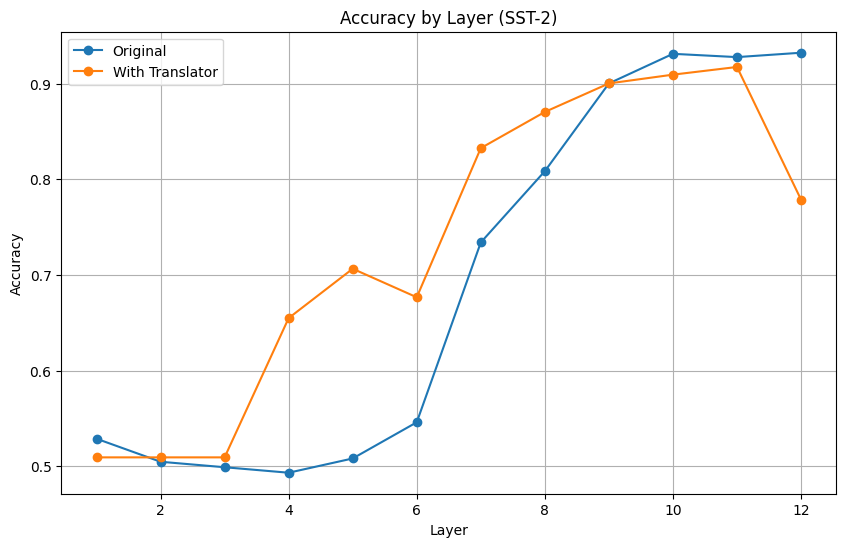

In [19]:
# 중간 레이어마다 Pooling + dropout 적용 (both bert and translator)

# load model
model_name = "JeremiahZ/bert-base-uncased-sst2"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# load translator
translator = translator.eval()
translator.load_state_dict(torch.load(f"translator/{trans}_{loss_name}_{epoch_num}.pt"))
translator.eval()

# Accuracy 저장
acc_original = []
acc_translated = []

# 레이어별로 정확도 계산
for layer in range(1, 13):
    correct_orig = 0
    correct_trans = 0
    total = 0

    for item in tqdm(val_dataset, desc=f"Layer {layer}"):
        text = item["sentence"]
        label = item["label"]
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden = outputs.hidden_states[layer]  # CLS 토큰
            pooled = model.bert.pooler(hidden)

            pooled_dropped = dropout(pooled)
            logits_orig = model.classifier(pooled_dropped)
            pred_orig = torch.argmax(logits_orig).item()

            trans_pooled = translator(pooled)
            trans_pooled_dropped = dropout(trans_pooled)
            logits_trans = model.classifier(trans_pooled_dropped)
            pred_trans = torch.argmax(logits_trans).item()

            correct_orig += int(pred_orig == label)
            correct_trans += int(pred_trans == label)
            total += 1

    acc_original.append(correct_orig / total)
    acc_translated.append(correct_trans / total)

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), acc_original, label="Original", marker='o')
plt.plot(range(1, 13), acc_translated, label="With Translator", marker='o')
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title("Accuracy by Layer (SST-2)")
plt.legend()
plt.grid(True)

# 저장
plt.savefig(f"img/{trans}_{loss_name}_{epoch_num}.png", dpi=300)  # 원하는 파일명과 해상도 설정 가능

plt.show()